Setup

`pip install transformer_lens einops pytorch jax matplotlib transformers` # and any other library you might need


In [1]:
from typing import List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as t
from torch import Tensor
import einops
from pprint import pprint as pp
from tqdm import tqdm
import circuitsvis as cv
from transformers import LlamaForCausalLM, LlamaTokenizer
t.set_grad_enabled(False)
from jaxtyping import Float, Int
import sys
# sys.path.append("../..")
# sys.path.append("..")


In [2]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {t.cuda.get_device_name(device)}")

Using device: cuda:0
Device name: NVIDIA A100 80GB PCIe


In [3]:
%load_ext autoreload
%autoreload 2
from interp_utils import (
    load_hooked_gpt2,
    plot_heatmap,
    pp_config,
    get_model_from_checkpoint_path,
)

ImportError: cannot import name 'get_model_from_checkpoint_path' from 'interp_utils' (/datadrive/madhur/mech_interp/TransformerLens/interp_utils.py)

In [21]:
from_pretrained_kwargs={
        "vocab_size": 54,
        "n_layer": 2,
        "n_embd": 128,
        # "n_ctx": 40,
        "n_head": 2,
        "bos_token_id": 1, #tokenizer.bos_token_id, 
        "eos_token_id": 2, #tokenizer.eos_token_id,
        "pad_token_id": 3, #tokenizer.pad_token_id,
        # "act_fn": "gelu_new",
        # "# tokenizer_name": "gpt2",
        # "device": device,
        # "seed": 762568
    }

ckpt_path = "/datadrive/madhur/world-models/src/training_outputs/FromSingularity/1cd24e9d-9a34-4da0-987e-527619b49ec8"
# ckpt_path = "/datadrive/madhur/world-models/src/training_outputs/cc0f50da-c754-4a08-8269-ac0f2e31f3bf"
model, tokenizer = load_hooked_gpt2(ckpt_path, device, from_pretrained_kwargs)

Loaded model's vocab size: 54
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
Successfully loaded hooked gpt2 model.


In [5]:
%load_ext autoreload
%autoreload 2
from transformer_lens import (
    utils,
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import to_numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
hf_model.state_dict().keys()

NameError: name 'hf_model' is not defined

In [6]:
model.state_dict().keys()

odict_keys(['embed.W_E', 'pos_embed.W_pos', 'blocks.0.ln1.w', 'blocks.0.ln1.b', 'blocks.0.ln2.w', 'blocks.0.ln2.b', 'blocks.0.attn.W_Q', 'blocks.0.attn.W_K', 'blocks.0.attn.W_V', 'blocks.0.attn.W_O', 'blocks.0.attn.b_Q', 'blocks.0.attn.b_K', 'blocks.0.attn.b_V', 'blocks.0.attn.b_O', 'blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'blocks.1.ln1.w', 'blocks.1.ln1.b', 'blocks.1.ln2.w', 'blocks.1.ln2.b', 'blocks.1.attn.W_Q', 'blocks.1.attn.W_K', 'blocks.1.attn.W_V', 'blocks.1.attn.W_O', 'blocks.1.attn.b_Q', 'blocks.1.attn.b_K', 'blocks.1.attn.b_V', 'blocks.1.attn.b_O', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.1.mlp.W_in', 'blocks.1.mlp.b_in', 'blocks.1.mlp.W_out', 'blocks.1.mlp.b_out', 'ln_final.w', 'ln_final.b', 'unembed.W_U', 'unembed.b_U'])

## Model Details

In [7]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre)

In [8]:
pp_config(model)

                 attention_dir	: causal
                     attn_only	: False
                    attn_types	: None
                        d_head	: 128
                         d_mlp	: 512
                       d_model	: 128
                       d_vocab	: 54
                   d_vocab_out	: 54
           default_prepend_bos	: True
                     gated_mlp	: False
                         n_ctx	: 1024
                     n_devices	: 1
                       n_heads	: 1
                      n_layers	: 2
                      n_params	: 393216
            normalization_type	: LN
             parallel_attn_mlp	: False
scale_attn_by_inverse_layer_idx	: False
                   use_attn_in	: False
               use_attn_result	: False
                use_attn_scale	: True


In [9]:
model.W_Q.shape, model.W_K.shape, model.W_V.shape, model.W_O.shape

(torch.Size([2, 1, 128, 128]),
 torch.Size([2, 1, 128, 128]),
 torch.Size([2, 1, 128, 128]),
 torch.Size([2, 1, 128, 128]))

## Model run

In [13]:
text = "P9 has O15, O14, O29. P6 has O24, O6, O20. P2 has O7, O5. Who has object O7? Answer: P2."
tokens = model.to_tokens(text)
str_tokens = model.to_str_tokens(text)
logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)

In [12]:
tokens

tensor([[ 1, 23,  5, 28,  6, 31,  6, 42,  4, 21,  5, 41,  6, 34,  6, 25,  4, 15,
          5, 37,  6, 53,  4, 10,  5, 11, 37,  8,  9,  7, 15,  4]],
       device='cuda:0')

In [13]:
str_tokens

['<|startoftext|>',
 'P9',
 'has',
 'O15',
 ',',
 'O14',
 ',',
 'O29',
 '.',
 'P6',
 'has',
 'O24',
 ',',
 'O6',
 ',',
 'O20',
 '.',
 'P2',
 'has',
 'O7',
 ',',
 'O5',
 '.',
 'Who',
 'has',
 'object',
 'O7',
 '?',
 'Answer',
 ':',
 'P2',
 '.']

In [14]:
type(model)

transformer_lens.HookedTransformer.HookedTransformer

In [15]:
logits.shape, tokens.shape

(torch.Size([1, 32, 54]), torch.Size([1, 32]))

## Interpreting

The names of all the hooks and their corresponding meanings in a language model's architecture are available [here](https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/full-merm.svg).

In [14]:
cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'ln_final.hook_scale', 'ln_final.

In [16]:
for key in cache.keys():
    if 'blocks.1' in key:
        print(f'{key:>40} => {cache[key].shape}')

                 blocks.1.hook_resid_pre => torch.Size([32, 128])
                 blocks.1.ln1.hook_scale => torch.Size([32, 1])
            blocks.1.ln1.hook_normalized => torch.Size([32, 128])
                    blocks.1.attn.hook_q => torch.Size([32, 1, 128])
                    blocks.1.attn.hook_k => torch.Size([32, 1, 128])
                    blocks.1.attn.hook_v => torch.Size([32, 1, 128])
          blocks.1.attn.hook_attn_scores => torch.Size([1, 32, 32])
              blocks.1.attn.hook_pattern => torch.Size([1, 32, 32])
                    blocks.1.attn.hook_z => torch.Size([32, 1, 128])
                  blocks.1.hook_attn_out => torch.Size([32, 128])
                 blocks.1.hook_resid_mid => torch.Size([32, 128])
                 blocks.1.ln2.hook_scale => torch.Size([32, 1])
            blocks.1.ln2.hook_normalized => torch.Size([32, 128])
                   blocks.1.mlp.hook_pre => torch.Size([32, 512])
                  blocks.1.mlp.hook_post => torch.Size([32, 512]

In [20]:
A = cache['blocks.1.hook_resid_pre']
B = cache['blocks.0.hook_resid_post']
C = cache['blocks.0.hook_resid_mid']
A.equal(B) # True
A.equal(C) # false

# Conclusion: blocks.(k).hook_resid_pre = blocks.(k-1).hook_resid_post

False

## Attention Visualization Using Hook

In [17]:
# create a tensor to store what you want to visualize (or use to replace with in case of patching)
# here, we create a tensor to store attention patterns
attention_pattern_store = t.zeros(
    (
        model.cfg.n_layers, 
        model.cfg.n_heads,
        tokens.shape[1], 
        tokens.shape[1]
    ), 
    device=model.cfg.device
)

In [18]:
attention_pattern_store.shape

torch.Size([2, 1, 32, 32])

In [19]:
# filter for the hook you want to visualize (or edit in case of patching)

def pattern_filter(name: str) -> bool:
    '''
    Returns True if the name is a pattern hook name.
    '''
    return name.endswith("pattern")

In [20]:
# step 3: write a function that does the reading for visualization (or writing in case of patching)

def attention_pattern_storing_function(
    pattern: Float[Tensor, "batch head_index dest_pos source_pos"], # (batch_size, n_heads, seq_len, seq_len)
    hook: HookPoint,
    ):
    '''
    Stores the attention pattern in the `attention_pattern_store` tensor for each layer and head.
    '''

    global attention_pattern_store # (n_layers, n_heads, seq_len, seq_len)
    
    # get layer index from hook name
    layer_index = int(hook.name.split(".")[1])

    # store the pattern in the store (or replace the pattern with something else in case of patching)
    attention_pattern_store[layer_index] = pattern

In [21]:
# step 4: run the model with the hook

model.run_with_hooks(
    tokens,
    return_type=None,
    fwd_hooks=[(
        pattern_filter,
        attention_pattern_storing_function,
    )],
)

In [22]:
for token in str_tokens:
    print(token, end=" | ")

<|startoftext|> | P9 | has | O15 | , | O14 | , | O29 | . | P6 | has | O24 | , | O6 | , | O20 | . | P2 | has | O7 | , | O5 | . | Who | has | object | O7 | ? | Answer | : | P2 | . | 

In [25]:
for layer_index in [0, 1]:
    print(f"Layer {layer_index} Attention Patterns")
    display(cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern_store[layer_index], show_axis_labels=True))

Layer 0 Attention Patterns


TypeError: attention_patterns() got an unexpected keyword argument 'show_axis_labels'

In [28]:
model.reset_hooks()

## Visualizing full OV/QK circuits / Factored Matrices

In [37]:
layer_heads = [
    [0, 0],
    [1, 0],
]

In [38]:
model.W_Q.shape, model.W_K.shape, model.W_V.shape, model.W_O.shape

(torch.Size([2, 1, 128, 128]),
 torch.Size([2, 1, 128, 128]),
 torch.Size([2, 1, 128, 128]),
 torch.Size([2, 1, 128, 128]))

In [40]:
# start with size (0, model.cfg.d_model)
W_O_concatenated = t.empty((0, model.cfg.d_model), device=model.cfg.device)
W_V_concatenated = t.empty((model.cfg.d_model, 0), device=model.cfg.device)

for layer, head in layer_heads:
    W_O_concatenated = t.cat([W_O_concatenated, model.W_O[layer, head]], dim=0)
    W_V_concatenated = t.cat([W_V_concatenated, model.W_V[layer, head]], dim=1)

In [41]:
W_O_concatenated.shape, W_V_concatenated.shape

(torch.Size([256, 128]), torch.Size([128, 256]))

In [42]:
W_OV_eff = model.W_E @ FactoredMatrix(W_V_concatenated, W_O_concatenated) @ model.W_U

In [43]:
W_OV_eff.shape, type(W_OV_eff)

(torch.Size([54, 54]), transformer_lens.FactoredMatrix.FactoredMatrix)

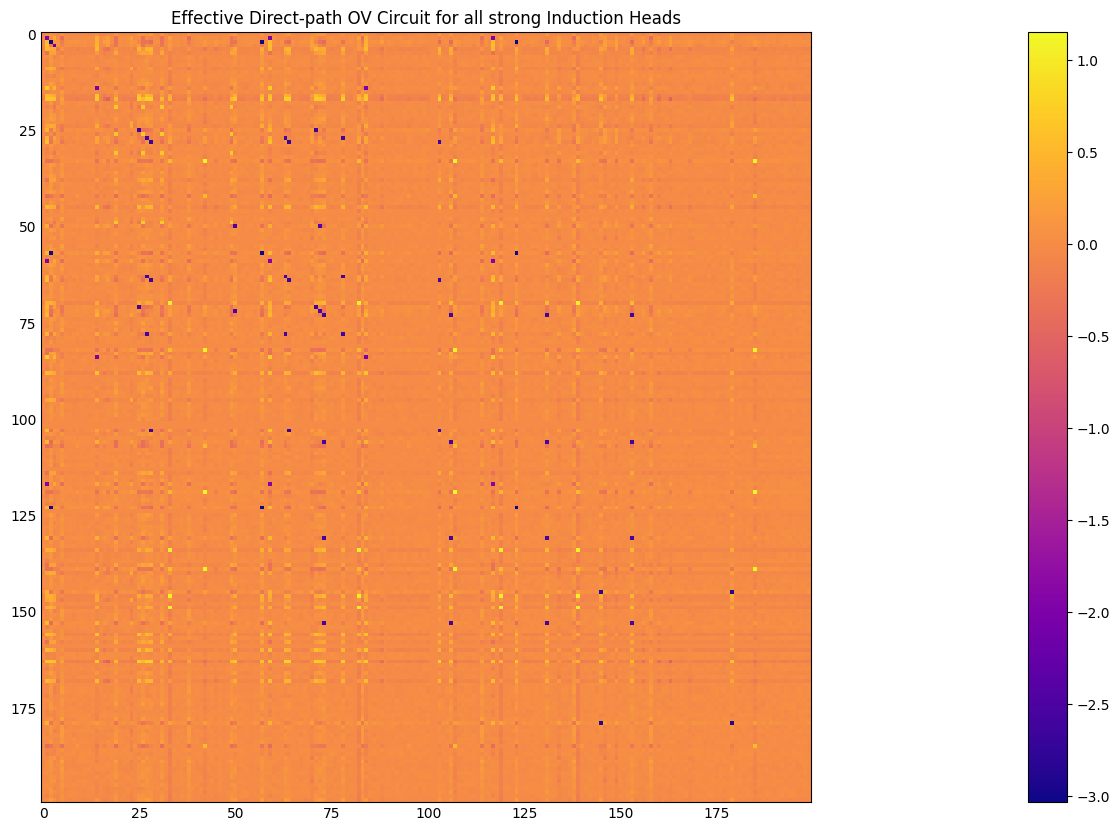

In [44]:
indices = t.randint(0, model.cfg.d_vocab, (200,))
plot_heatmap(
    W_OV_eff[indices, indices].AB * 10,
    labels=[
        [f"Input token {i}" for i in range(len(indices))], 
        [f"Logit output {i}" for i in range(len(indices))]
        ],
    title="Effective Direct-path OV Circuit for all strong Induction Heads",
    sizex=20,
    sizey=10,
    show_values=False,
    show_labels=False,
    auto_limits=True,
    save=None,
    )

Happy interpreting, all the best!

## Head Detectors - Using the Cache

In [45]:
def prev_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which appear to be previous-token heads
    '''
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            # take avg of sub-diagonal elements
            score = attention_pattern.diagonal(-1).mean()
            if score > 0.5:
                attn_heads.append(f"{layer}.{head}")
    return attn_heads

In [47]:
print("Heads attending to previous token = ", ", ".join(prev_attn_detector(cache)))

Heads attending to previous token =  
